In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

2024-07-19 14:01:00.460872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 14:01:00.614433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 14:01:00.671558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 14:01:00.687529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 14:01:00.801980: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if GPU is detected.

class GpuDetector:
    @staticmethod
    def is_gpu_detected() -> bool:
        list_of_gpus = tf.config.list_physical_devices(device_type="GPU")
        number_of_gpus: int = len(list_of_gpus)
        if number_of_gpus >= 1:
            return True
        else:
            return False

gpu_detected: bool = GpuDetector.is_gpu_detected()
if gpu_detected:
    print("GPU detected.")
else:
    print("GPU NOT DETECTED!")

GPU detected.


I0000 00:00:1721397663.217894      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721397663.260994      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721397663.261028      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Parameters.

# RNG.
SEED: int = 42

# Dataset.
DATASET_NAME: str = "speech_commands"
DATASET_DIRECTORY: str = "/app/downloads/dataset"
BATCH_SIZE: int = 64
LABELS = ["down",
          "go",
          "left",
          "no",
          "off",
          "on",
          "right",
          "stop",
          "up",
          "yes",
          "silence",
          "unknown"]
NUMBER_OF_LABELS: int = len(LABELS)
I: int = 0

# Frequency.
SAMPLING_FREQUENCY: int = 16000
FFT_LENGTH: int = 512  # Must be a power of 2.
# Divided by two because spectrum is mirrored. 257.
NUMBER_OF_FREQUENCY_BINS: int = FFT_LENGTH // 2 + 1

# Time.
NUMBER_OF_SECONDS_IN_BUFFER: int = 1
NUMBER_OF_SAMPLES_IN_BUFFER: int = (SAMPLING_FREQUENCY
                                    * NUMBER_OF_SECONDS_IN_BUFFER) # 16000.
FRAME_LENGTH: int = FFT_LENGTH  # 32 ms.
FRAME_STEP: int = 256  # 16 ms.
NUMBER_OF_FRAMES: int = ((NUMBER_OF_SAMPLES_IN_BUFFER - FRAME_LENGTH)
                         // FRAME_STEP) + 1 # 61.

# Mel.
LOWER_LIMIT_HZ: int = 50  # Wideband audio.
UPPER_LIMIT_HZ: int = 7000  # Wideband audio.
NUMBER_OF_MEL_BINS: int = 40

# Model.
INPUT_SHAPE = (NUMBER_OF_FRAMES, NUMBER_OF_MEL_BINS, 1)
LEARNING_RATE: float = 0.001
EPOCHS: int = 30
FULL_MODEL_PATH: str = "/app/build/full_model.keras"
LITE_MODEL_PATH: str = "/app/build/lite_model.tflite"

In [4]:
# Seed RNG.

tf.random.set_seed(seed=SEED)

In [5]:
# Load dataset.

class DatasetLoader:
    @staticmethod
    def load(dataset_name: str,
             dataset_directory: str,
             batch_size: int,
             seed: int) -> tuple[tf.data.Dataset,
                                 tf.data.Dataset,
                                 tf.data.Dataset]:
        train_ds: tf.data.Dataset
        validation_ds: tf.data.Dataset
        test_ds: tf.data.Dataset

        train_ds, validation_ds, test_ds = tfds.load(
            name=dataset_name,
            split=["train", "validation", "test"],
            data_dir=dataset_directory,
            batch_size=batch_size,
            shuffle_files=True,
            download=True,
            as_supervised=True,
            read_config=tfds.ReadConfig(shuffle_seed=seed))

        return (train_ds, validation_ds, test_ds)

train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
test_ds: tf.data.Dataset
train_ds, validation_ds, test_ds = DatasetLoader.load(
    dataset_name=DATASET_NAME,
    dataset_directory=DATASET_DIRECTORY,
    batch_size=BATCH_SIZE,
    seed=SEED)

2024-07-19 14:01:03.333999: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /app/downloads/dataset/speech_commands/incomplete.BY2GW4_0.0.3/speech_commands-train.tfrecord*...:  …

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /app/downloads/dataset/speech_commands/incomplete.BY2GW4_0.0.3/speech_commands-validation.tfrecord*.…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /app/downloads/dataset/speech_commands/incomplete.BY2GW4_0.0.3/speech_commands-test.tfrecord*...:   …

Dataset speech_commands downloaded and prepared to /app/downloads/dataset/speech_commands/0.0.3. Subsequent calls will reuse this data.


I0000 00:00:1721398113.712788      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721398113.712844      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721398113.712857      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721398113.883175      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721398113.883215      27 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-19

In [6]:
# Examine dataset.

it_train_ds: tf.data.Iterator = iter(train_ds)
batch_of_audio: tf.Tensor
batch_of_labels: tf.Tensor
batch_of_audio, batch_of_labels = it_train_ds.next()
audio: tf.Tensor = batch_of_audio[I]
label: tf.Tensor = batch_of_labels[I]
print(f"Audio shape: {audio.shape}")
print(f"Audio data type: {audio.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label data type: {label.dtype}")

Audio shape: (16000,)
Audio data type: <dtype: 'int16'>
Label shape: ()
Label data type: <dtype: 'int64'>


2024-07-19 14:09:18.318330: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-19 14:09:23.546622: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


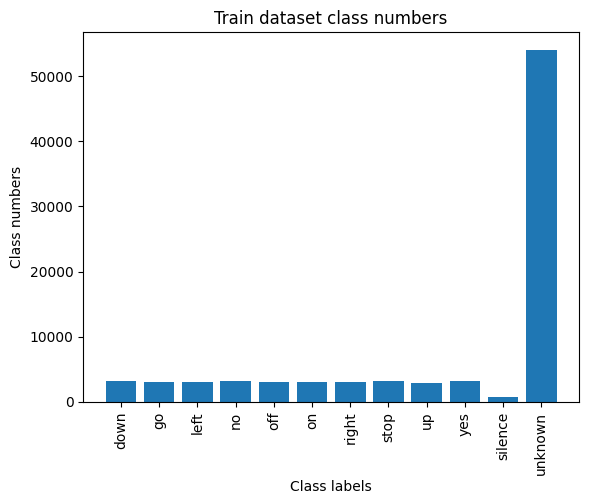

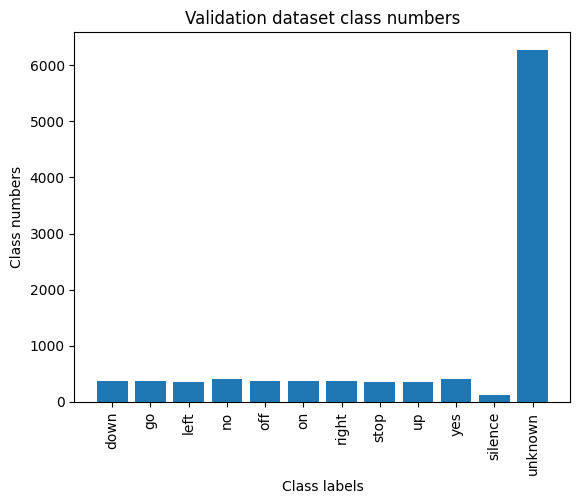

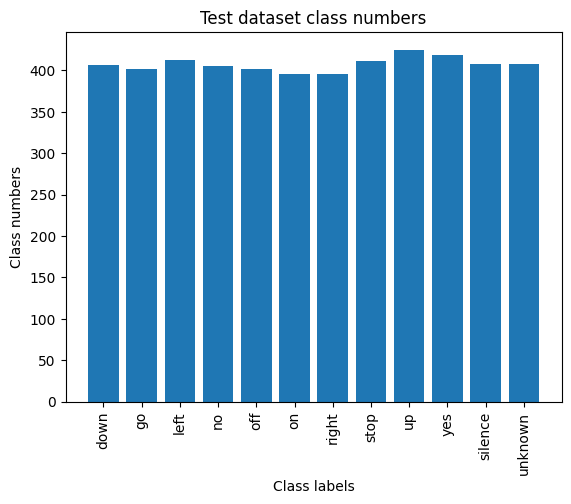

In [7]:
# Calculate class numbers.

class ClassNumbersCalculator:
    @staticmethod
    def calculate(dataset: tf.data.Dataset,
                  number_of_labels: int):
        class_numbers = {label: 0 for label in range(0, number_of_labels, 1)}

        for batch_of_audio, batch_of_labels in dataset:
            for label in batch_of_labels:
                label: np.ndarray = label.numpy()
                class_numbers[label] = class_numbers[label] + 1

        return class_numbers

    @staticmethod
    def plot(title: str,
             labels,
             class_numbers):
        label_indexes = list(class_numbers.keys())
        label_strings = [labels[index] for index in label_indexes]
        class_number_values = list(class_numbers.values())

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        axes.bar(x=label_indexes,
                 height=class_number_values,
                 width=0.8,
                 bottom=0,
                 align="center")
        
        axes.set_title(label=title)
        axes.set_xlabel(xlabel="Class labels")
        axes.set_ylabel(ylabel="Class numbers")
        axes.set_xticks(ticks=label_indexes,
                        labels=label_strings,
                        rotation="vertical")

        plt.show()
        plt.close(fig=figure)

train_ds_class_numbers = ClassNumbersCalculator.calculate(
    dataset=train_ds,
    number_of_labels=NUMBER_OF_LABELS)
validation_ds_class_numbers = ClassNumbersCalculator.calculate(
    dataset=validation_ds,
    number_of_labels=NUMBER_OF_LABELS)
test_ds_class_numbers = ClassNumbersCalculator.calculate(
    dataset=test_ds,
    number_of_labels=NUMBER_OF_LABELS)

ClassNumbersCalculator.plot(title="Train dataset class numbers",
                            labels=LABELS,
                            class_numbers=train_ds_class_numbers)
ClassNumbersCalculator.plot(title="Validation dataset class numbers",
                            labels=LABELS,
                            class_numbers=validation_ds_class_numbers)
ClassNumbersCalculator.plot(title="Test dataset class numbers",
                            labels=LABELS,
                            class_numbers=test_ds_class_numbers)

In [8]:
# Calculate class weights.

class ClassWeightsCalculator:
    @staticmethod
    def calculate(class_numbers,
                  number_of_labels: int):
        total_class_numbers: int = sum(class_numbers.values())

        class_weights = {label: 0 for label in range(0, number_of_labels, 1)}
        for label in class_weights:
            class_number: int = class_numbers[label]
            class_weight: float = ((total_class_numbers / class_number)
                                   / number_of_labels)
            class_weights[label] = class_weight

        return class_weights

class_weights = ClassWeightsCalculator.calculate(
    class_numbers=train_ds_class_numbers,
    number_of_labels=NUMBER_OF_LABELS)

print("Class weights:")
for label, class_weight in class_weights.items():
    print(f"{label} ({LABELS[label]}): \t {class_weight}")

Class weights:
0 (down): 	 2.273744947883429
1 (go): 	 2.294242326679545
2 (left): 	 2.3463670288662057
3 (no): 	 2.2766506922257723
4 (off): 	 2.3992985409652077
5 (on): 	 2.309111039101318
6 (right): 	 2.360356630230761
7 (stop): 	 2.2905550198221367
8 (up): 	 2.417203753957485
9 (yes): 	 2.207533044196613
10 (silence): 	 10.667539920159681
11 (unknown): 	 0.1317808312066181


New audio shape: (1, 16000)
New audio data type: <dtype: 'float32'>


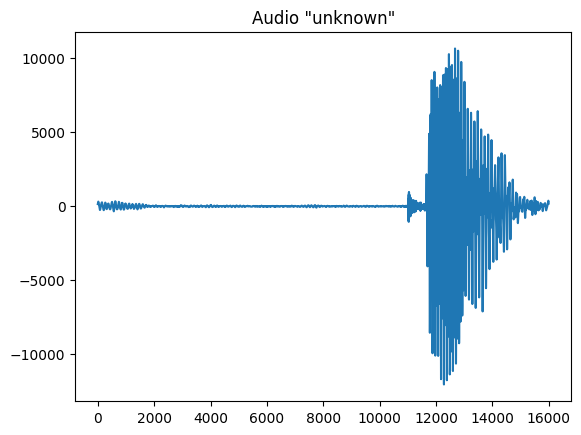

In [9]:
# Preprocess dataset. Convert audio to log mel spectrogram.

# Audio.

class Audio:
    @staticmethod
    def get_audio(audio: tf.Tensor,
                  number_of_samples_in_buffer: int) -> tf.Tensor:
        audio = tf.reshape(tensor=audio,
                           shape=[-1, number_of_samples_in_buffer])
        audio = tf.cast(x=audio,
                        dtype=tf.float32)
        return audio # Shape = (BATCH_SIZE, NUMBER_OF_SAMPLES_IN_BUFFER)

    @staticmethod
    def plot(audio: tf.Tensor,
             label: tf.Tensor,
             labels):
        audio = tf.squeeze(input=audio,
                           axis=0)

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        axes.plot(audio)
        
        label_index: np.ndarray = label.numpy()
        label_string: str = labels[label_index]
        title: str = f"Audio \"{label_string}\""
        axes.set_title(label=title)

        plt.show()
        plt.close(fig=figure)

it_train_ds: tf.data.Iterator = iter(train_ds)
batch_of_audio: tf.Tensor
batch_of_labels: tf.Tensor
batch_of_audio, batch_of_labels = it_train_ds.next()
audio: tf.Tensor = batch_of_audio[I]
label: tf.Tensor = batch_of_labels[I]

audio = Audio.get_audio(audio=audio,
                        number_of_samples_in_buffer=NUMBER_OF_SAMPLES_IN_BUFFER)
print(f"New audio shape: {audio.shape}")
print(f"New audio data type: {audio.dtype}")
Audio.plot(audio=audio,
           label=label,
           labels=LABELS)

Spectrogram shape = (1, 61, 257)
Spectrogram data type = <dtype: 'float32'>


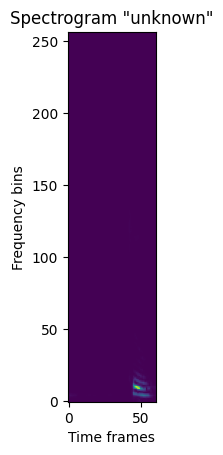

In [10]:
# Spectrogram.

class Spectrogram:
    @staticmethod
    def get_spectrogram(audio: tf.Tensor,
                        frame_length: int,
                        frame_step: int) -> tf.Tensor:
        spectrogram: tf.Tensor = tf.signal.stft(signals=audio,
                                                frame_length=frame_length,
                                                frame_step=frame_step)
        spectrogram = tf.math.abs(spectrogram)
        # Shape = (BATCH_SIZE, NUMBER_OF_FRAMES, NUMBER_OF_FREQUENCY_BINS)
        return spectrogram

    @staticmethod
    def plot(spectrogram: tf.Tensor,
             label: tf.Tensor,
             labels):
        spectrogram = tf.squeeze(input=spectrogram,
                                 axis=0)
        spectrogram = tf.transpose(spectrogram)
        spectrogram: np.ndarray = spectrogram.numpy()

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        axes.imshow(X=spectrogram,
                    origin="lower")
        
        label_index: np.ndarray = label.numpy()
        label_string: str = labels[label_index]
        title: str = f"Spectrogram \"{label_string}\""
        axes.set_title(label=title)
        axes.set_xlabel(xlabel="Time frames")
        axes.set_ylabel(ylabel="Frequency bins")

        plt.show()
        plt.close(fig=figure)

spectrogram: tf.Tensor = Spectrogram.get_spectrogram(audio=audio,
                                                     frame_length=FRAME_LENGTH,
                                                     frame_step=FRAME_STEP)
print(f"Spectrogram shape = {spectrogram.shape}")
print(f"Spectrogram data type = {spectrogram.dtype}")
Spectrogram.plot(spectrogram=spectrogram,
                 label=label,
                 labels=LABELS)

Lin mel matrix shape = (257, 40)
Lin mel matrix data type = <dtype: 'float32'>


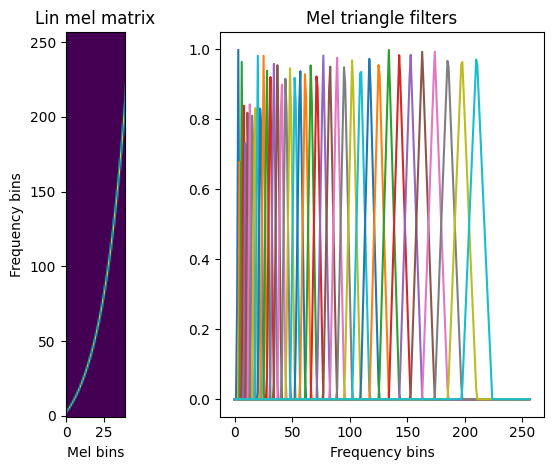

In [11]:
# Lin mel matrix.

class LinMelMatrix:
    @staticmethod
    def get_lin_mel_matrix(sampling_frequency: int,
                           lower_limit_hz: int,
                           upper_limit_hz: int,
                           number_of_frequency_bins: int,
                           number_of_mel_bins: int) -> tf.Tensor:
        lin_mel_matrix: tf.Tensor = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=number_of_mel_bins,
            num_spectrogram_bins=number_of_frequency_bins,
            sample_rate=sampling_frequency,
            lower_edge_hertz=lower_limit_hz,
            upper_edge_hertz=upper_limit_hz
        )
        # Shape = (NUMBER_OF_FREQUENCY_BINS, NUMBER_OF_MEL_BINS)
        return lin_mel_matrix

    @staticmethod
    def plot(lin_mel_matrix: tf.Tensor):
        lin_mel_matrix: np.ndarray = lin_mel_matrix.numpy()

        figure: matplotlib.figure.Figure = plt.figure()

        # Plot lin mel matrix.
        axes1: matplotlib.axes.Axes = figure.add_subplot(1, 2, 1)
        axes1.imshow(X=lin_mel_matrix,
                     origin="lower")
                     
        axes1.set_title(label="Lin mel matrix")
        axes1.set_xlabel(xlabel="Mel bins")
        axes1.set_ylabel(ylabel="Frequency bins")

        # Plot mel triangle filters.
        axes2: matplotlib.axes.Axes = figure.add_subplot(1, 2, 2)
        x = range(0, lin_mel_matrix.shape[0], 1)
        for mel_bin in range(0, lin_mel_matrix.shape[1], 1):
            y = lin_mel_matrix[:, mel_bin]
            axes2.plot(x, y)

        axes2.set_title(label="Mel triangle filters")
        axes2.set_xlabel(xlabel="Frequency bins")

        figure.tight_layout()
        plt.show()
        plt.close(fig=figure)

LIN_MEL_MATRIX: tf.Tensor = LinMelMatrix.get_lin_mel_matrix(
    sampling_frequency=SAMPLING_FREQUENCY,
    lower_limit_hz=LOWER_LIMIT_HZ,
    upper_limit_hz=UPPER_LIMIT_HZ,
    number_of_frequency_bins=NUMBER_OF_FREQUENCY_BINS,
    number_of_mel_bins=NUMBER_OF_MEL_BINS)
print(f"Lin mel matrix shape = {LIN_MEL_MATRIX.shape}")
print(f"Lin mel matrix data type = {LIN_MEL_MATRIX.dtype}")
LinMelMatrix.plot(lin_mel_matrix=LIN_MEL_MATRIX)

Mel spectrogram shape = (1, 61, 40)
Mel spectrogram data type = <dtype: 'float32'>


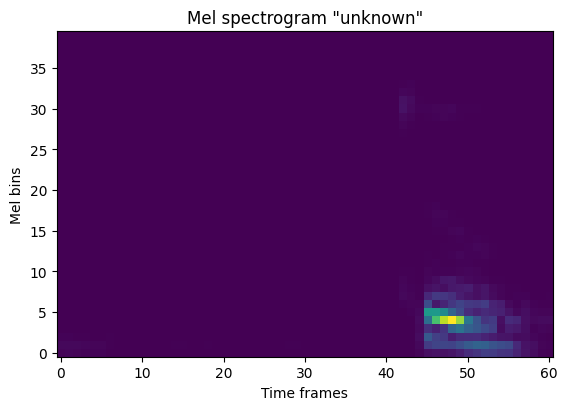

In [12]:
# Mel spectrogram.

class MelSpectrogram:
    @staticmethod
    def get_mel_spectrogram(spectrogram: tf.Tensor,
                            lin_mel_matrix: tf.Tensor) -> tf.Tensor:
        mel_spectrogram: tf.Tensor = tf.linalg.matmul(a=spectrogram,
                                                      b=lin_mel_matrix)
        # Shape = (BATCH_SIZE, NUMBER_OF_FRAMES, NUMBER_OF_MEL_BINS)
        return mel_spectrogram

    @staticmethod
    def plot(mel_spectrogram: tf.Tensor,
             label: tf.Tensor,
             labels):
        mel_spectrogram = tf.squeeze(input=mel_spectrogram,
                                     axis=0)
        mel_spectrogram = tf.transpose(mel_spectrogram)
        mel_spectrogram: np.ndarray = mel_spectrogram.numpy()

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        axes.imshow(X=mel_spectrogram,
                    origin="lower")
        
        label_index: np.ndarray = label.numpy()
        label_string: str = labels[label_index]
        title: str = f"Mel spectrogram \"{label_string}\""
        axes.set_title(label=title)
        axes.set_xlabel(xlabel="Time frames")
        axes.set_ylabel(ylabel="Mel bins")
        
        plt.show()
        plt.close(fig=figure)

mel_spectrogram: tf.Tensor = MelSpectrogram.get_mel_spectrogram(
    spectrogram=spectrogram,
    lin_mel_matrix=LIN_MEL_MATRIX)
print(f"Mel spectrogram shape = {mel_spectrogram.shape}")
print(f"Mel spectrogram data type = {mel_spectrogram.dtype}")
MelSpectrogram.plot(mel_spectrogram=mel_spectrogram,
                    label=label,
                    labels=LABELS)

Log mel spectrogram shape = (1, 61, 40, 1)
Log mel spectrogram data type = <dtype: 'float32'>


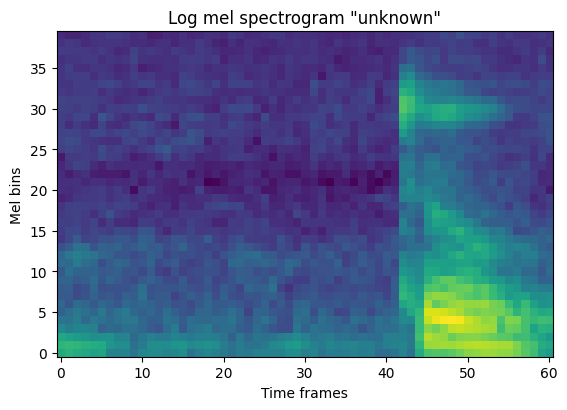

In [13]:
# Log mel spectrogram.

class LogMelSpectrogram:
    @staticmethod
    def get_log_mel_spectrogram(mel_spectrogram: tf.Tensor) -> tf.Tensor:
        mel_spectrogram = tf.math.add(x=mel_spectrogram,
                                      y=tf.keras.backend.epsilon())
        log_mel_spectrogram: tf.Tensor = tf.math.log(x=mel_spectrogram)
        log_mel_spectrogram = tf.expand_dims(input=log_mel_spectrogram,
                                             axis=-1)
        # Shape = (BATCH_SIZE, NUMBER_OF_FRAMES, NUMBER_OF_MEL_BINS)
        return log_mel_spectrogram

    @staticmethod
    def plot(log_mel_spectrogram: tf.Tensor,
             label: tf.Tensor,
             labels):
        log_mel_spectrogram = tf.squeeze(input=log_mel_spectrogram,
                                         axis=0)
        log_mel_spectrogram = tf.squeeze(input=log_mel_spectrogram,
                                         axis=-1)
        log_mel_spectrogram = tf.transpose(log_mel_spectrogram)
        log_mel_spectrogram: np.ndarray = log_mel_spectrogram.numpy()

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        axes.imshow(X=log_mel_spectrogram,
                    origin="lower")
        
        label_index: np.ndarray = label.numpy()
        label_string: str = labels[label_index]
        title: str = f"Log mel spectrogram \"{label_string}\""
        axes.set_title(label=title)
        axes.set_xlabel(xlabel="Time frames")
        axes.set_ylabel(ylabel="Mel bins")

        plt.show()
        plt.close(fig=figure)

log_mel_spectrogram: tf.Tensor = LogMelSpectrogram.get_log_mel_spectrogram(
    mel_spectrogram=mel_spectrogram)
print(f"Log mel spectrogram shape = {log_mel_spectrogram.shape}")
print(f"Log mel spectrogram data type = {log_mel_spectrogram.dtype}")
LogMelSpectrogram.plot(log_mel_spectrogram=log_mel_spectrogram,
                       label=label,
                       labels=LABELS)

In [14]:
# Preprocess dataset before training model.
# Convert dataset of audio to dataset of log mel spectrograms.

class PreprocessorBeforeTraining:
    def __init__(self,
                 number_of_samples_in_buffer: int,
                 frame_length: int,
                 frame_step: int,
                 lin_mel_matrix: tf.Tensor):
        super().__init__()
        self._number_of_samples_in_buffer = number_of_samples_in_buffer
        self._frame_length: int = frame_length
        self._frame_step: int = frame_step
        self._lin_mel_matrix: int = lin_mel_matrix

    def preprocess(self,
                   dataset: tf.data.Dataset) -> tf.data.Dataset:
        dataset = dataset.map(map_func=self._map_function,
                              num_parallel_calls=tf.data.AUTOTUNE,
                              deterministic=True)
        return dataset

    def _map_function(self,
                      audio: tf.Tensor,
                      label: tf.Tensor) -> tuple[tf.Tensor,
                                                 tf.Tensor]:
        audio = Audio.get_audio(
            audio=audio,
            number_of_samples_in_buffer=self._number_of_samples_in_buffer)
        spectrogram: tf.Tensor = Spectrogram.get_spectrogram(
            audio=audio,
            frame_length=self._frame_length,
            frame_step=self._frame_step)
        mel_spectrogram: tf.Tensor = MelSpectrogram.get_mel_spectrogram(
            spectrogram=spectrogram,
            lin_mel_matrix=self._lin_mel_matrix)
        log_mel_spectrogram: tf.Tensor = \
            LogMelSpectrogram.get_log_mel_spectrogram(
                mel_spectrogram=mel_spectrogram)
        return (log_mel_spectrogram, label)
    
preprocessor_before_training: PreprocessorBeforeTraining = \
    PreprocessorBeforeTraining(
        number_of_samples_in_buffer=NUMBER_OF_SAMPLES_IN_BUFFER,
        frame_length=FRAME_LENGTH,
        frame_step=FRAME_STEP,
        lin_mel_matrix=LIN_MEL_MATRIX)

train_preprocessed_ds = preprocessor_before_training.preprocess(
    dataset=train_ds)
validation_preprocessed_ds = preprocessor_before_training.preprocess(
    dataset=validation_ds)
test_preprocessed_ds = preprocessor_before_training.preprocess(
    dataset=test_ds)

train_preprocessed_ds = train_preprocessed_ds.cache().prefetch(
    buffer_size=tf.data.AUTOTUNE)
validation_preprocessed_ds = validation_preprocessed_ds.cache().prefetch(
    buffer_size=tf.data.AUTOTUNE)
test_preprocessed_ds = test_preprocessed_ds.cache().prefetch(
    buffer_size=tf.data.AUTOTUNE)

In [15]:
# Examine preprocessed dataset.

it_train_preprocessed_ds: tf.data.Iterator = iter(train_preprocessed_ds)
batch_of_log_mel_spectrograms: tf.Tensor
batch_of_labels: tf.Tensor
batch_of_log_mel_spectrograms, batch_of_labels = it_train_preprocessed_ds.next()
log_mel_spectrogram: tf.Tensor = batch_of_log_mel_spectrograms[I]
label: tf.Tensor = batch_of_labels[I]
print(f"Log mel spectrogram shape = {log_mel_spectrogram.shape}")
print(f"Log mel spectrogram data type = {log_mel_spectrogram.dtype}")
print(f"Label shape = {label.shape}")
print(f"Label data type: {label.dtype}")

Log mel spectrogram shape = (61, 40, 1)
Log mel spectrogram data type = <dtype: 'float32'>
Label shape = ()
Label data type: <dtype: 'int64'>


In [16]:
# Model.

class Model:
    @staticmethod
    def get_model(train_preprocessed_ds: tf.data.Dataset,
                  input_shape,
                  number_of_labels: int,
                  learning_rate: float) -> tf.keras.Sequential:
        normalization_layer: tf.keras.layers.Normalization = \
            tf.keras.layers.Normalization(name="normalization")
        normalization_layer.adapt(data=train_preprocessed_ds.map(
            map_func=lambda log_mel_spectrogram, label: log_mel_spectrogram))

        model: tf.keras.Sequential = tf.keras.Sequential(
            name="model",
            layers=
            [
                tf.keras.layers.InputLayer(name="input_layer",
                                           shape=input_shape),
                normalization_layer,
                tf.keras.layers.Conv2D(name="conv_2d_1",
                                       filters=32,
                                       kernel_size=(3, 3),
                                       activation=tf.keras.activations.relu),
                tf.keras.layers.MaxPool2D(name="max_pool_2d_1",
                                          pool_size=(2, 2)),
                tf.keras.layers.Conv2D(name="conv_2d_2",
                                       filters=64,
                                       kernel_size=(3, 3),
                                       activation=tf.keras.activations.relu),
                tf.keras.layers.MaxPool2D(name="max_pool_2d_2",
                                          pool_size=(2, 2)),
                tf.keras.layers.Dropout(name="dropout_1",
                                        rate=0.25),
                tf.keras.layers.Flatten(name="flatten"),
                tf.keras.layers.Dense(name="dense_1",
                                      units=128,
                                      activation=tf.keras.activations.relu),
                tf.keras.layers.Dropout(name="dropout_2",
                                        rate=0.5),
                tf.keras.layers.Dense(name="dense_2",
                                      units=number_of_labels)
            ]
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        return model

model: tf.keras.Sequential = Model.get_model(
    train_preprocessed_ds=train_preprocessed_ds,
    input_shape=INPUT_SHAPE,
    number_of_labels=NUMBER_OF_LABELS,
    learning_rate=LEARNING_RATE)
model.summary()

2024-07-19 14:09:38.028744: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 61, 40, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2d_1 (Conv2D)              │ (None, 59, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2d_1 (MaxPooling2D)    │ (None, 29, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2d_2 (Conv2D)              │ (None, 27, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2d_2 (MaxPooling2D)    │ (None, 13, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       852,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,463 (3.33 MB)

 Trainable params: 872,460 (3.33 MB)

 Non-trainable params: 3 (16.00 B)

In [17]:
# Train model.

history = model.fit(x=train_preprocessed_ds,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=2,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=False,
                        start_from_epoch=0)],
                    validation_data=validation_preprocessed_ds,
                    class_weight=class_weights,
                    initial_epoch=0,
                    steps_per_epoch=None,
                    validation_steps=None,
                    validation_freq=1)

Epoch 1/30


I0000 00:00:1721398178.857341     110 service.cc:146] XLA service 0x7f2f5000c610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721398178.857700     110 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-07-19 14:09:38.902114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 14:09:39.023077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


  46/1337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.4559 - sparse_categorical_accuracy: 0.1912  

I0000 00:00:1721398181.152120     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1337/1337 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.6835 - sparse_categorical_accuracy: 0.3013 - val_loss: 0.9781 - val_sparse_categorical_accuracy: 0.6341
Epoch 2/30
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.7684 - sparse_categorical_accuracy: 0.5548 - val_loss: 0.7845 - val_sparse_categorical_accuracy: 0.6980
Epoch 3/30
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.6914 - val_sparse_categorical_accuracy: 0.7361
Epoch 4/30
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.5174 - sparse_categorical_accuracy: 0.6674 - val_loss: 0.6388 - val_sparse_categorical_accuracy: 0.7606
Epoch 5/30
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4595 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.5986 - val_sparse_categorical_accuracy: 0.7794
Epoch 6/30
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.5525 - val_sparse_categorical_accuracy: 0.7919
Ep

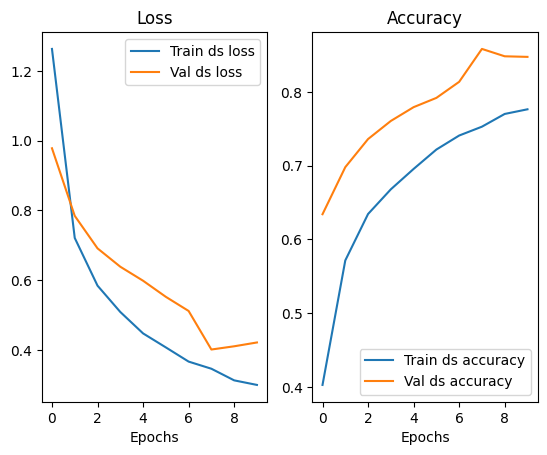

In [18]:
# Plot metrics.

class MetricsPlotter:
    @staticmethod
    def plot(history):
        epochs = history.epoch
        metrics = history.history
        loss = metrics["loss"]
        val_loss = metrics["val_loss"]
        sparse_categorical_accuracy = metrics["sparse_categorical_accuracy"]
        val_sparse_categorical_accuracy \
            = metrics["val_sparse_categorical_accuracy"]

        figure: matplotlib.figure.Figure = plt.figure()

        axes1: matplotlib.axes.Axes = figure.add_subplot(1, 2, 1)
        axes1.plot(epochs,
                   loss,
                   label="Train ds loss")
        axes1.plot(epochs,
                   val_loss,
                   label="Val ds loss")
        
        axes1.set_title(label="Loss")
        axes1.set_xlabel(xlabel="Epochs")
        axes1.legend()

        axes2: matplotlib.axes.Axes = figure.add_subplot(1, 2, 2)
        axes2.plot(epochs,
                   sparse_categorical_accuracy,
                   label="Train ds accuracy")
        axes2.plot(epochs,
                   val_sparse_categorical_accuracy,
                   label="Val ds accuracy")

        axes2.set_title(label="Accuracy")
        axes2.set_xlabel(xlabel="Epochs")
        axes2.legend()

        plt.show()
        plt.close(fig=figure)

MetricsPlotter.plot(history=history)

In [19]:
# Evaluate model on test set.

test_metrics = model.evaluate(x=test_preprocessed_ds,
                              verbose=1,
                              return_dict=True)

for metric_name, metric_value in test_metrics.items():
    print(f"Test dataset {metric_name}: {metric_value}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3009 - sparse_categorical_accuracy: 0.9071
Test dataset loss: 0.30265942215919495
Test dataset sparse_categorical_accuracy: 0.907566487789154


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


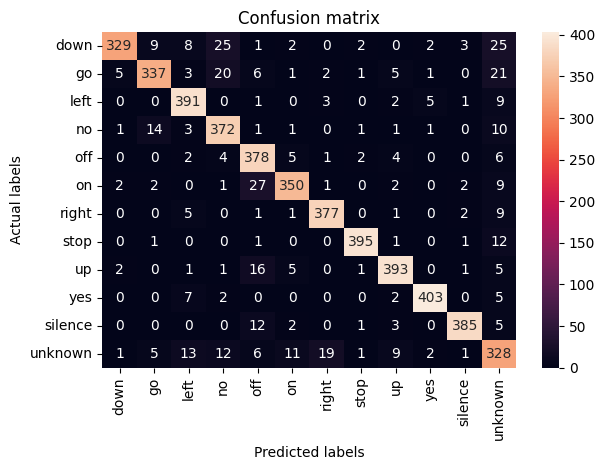

In [20]:
# Display confusion matrix.

class ConfusionMatrix:
    @staticmethod
    def _get_actual_labels(
        model: tf.keras.Sequential,
        test_preprocessed_ds: tf.data.Dataset) -> tf.Tensor:

        test_actual_labels: list[int] = []
        for batch_of_mfcc, batch_of_labels in test_preprocessed_ds:
            for label in batch_of_labels:
                test_actual_labels.append(label.numpy())

        test_actual_labels: tf.Tensor = tf.convert_to_tensor(
            value=test_actual_labels,
            dtype=tf.int32)
        return test_actual_labels
    
    @staticmethod
    def _get_predicted_labels(
        model: tf.keras.Sequential,
        test_preprocessed_ds: tf.data.Dataset) -> tf.Tensor:
        
        test_predicted_probabilities: np.ndarray = model.predict(
            x=test_preprocessed_ds,
            verbose=1,
            steps=None)
        test_predicted_labels: tf.Tensor = tf.math.argmax(
            input=test_predicted_probabilities,
            axis=-1,
            output_type=tf.int32)
        return test_predicted_labels

    @staticmethod
    def plot(model: tf.keras.Sequential,
             test_preprocessed_ds: tf.data.Dataset,
             labels):
        test_actual_labels: tf.Tensor = ConfusionMatrix._get_actual_labels(
            model=model,
            test_preprocessed_ds=test_preprocessed_ds)
        test_predicted_labels: tf.Tensor = ConfusionMatrix._get_predicted_labels(
            model=model,
            test_preprocessed_ds=test_preprocessed_ds)

        confusion_matrix: tf.Tensor = tf.math.confusion_matrix(
            labels=test_actual_labels,
            predictions=test_predicted_labels)

        figure: matplotlib.figure.Figure = plt.figure()
        axes: matplotlib.axes.Axes = figure.add_subplot()
        sns.heatmap(data=confusion_matrix,
                    annot=True,
                    fmt="g",
                    xticklabels=labels,
                    yticklabels=labels)
        axes.set_title(label="Confusion matrix")
        axes.set_xlabel(xlabel="Predicted labels")
        axes.set_ylabel(ylabel="Actual labels")
        figure.tight_layout()
        plt.show()
        plt.close(fig=figure)

ConfusionMatrix.plot(model=model,
                     test_preprocessed_ds=test_preprocessed_ds,
                     labels=LABELS)

In [21]:
# It is convenient to use raw audio as input to the model.
# But currently our model uses log mel spectrogram as input.
# That's why we should add a preprocessing layer to the model itself.

@tf.keras.utils.register_keras_serializable()
class PreprocessorAfterTraining(tf.keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self,
             audio: tf.Tensor,
             number_of_samples_in_buffer: int,
             frame_length: int,
             frame_step: int,
             lin_mel_matrix: tf.Tensor) -> tf.Tensor:
        audio = Audio.get_audio(
            audio=audio,
            number_of_samples_in_buffer=number_of_samples_in_buffer)
        spectrogram: tf.Tensor = Spectrogram.get_spectrogram(
            audio=audio,
            frame_length=frame_length,
            frame_step=frame_step)
        mel_spectrogram: tf.Tensor = MelSpectrogram.get_mel_spectrogram(
            spectrogram=spectrogram,
            lin_mel_matrix=lin_mel_matrix)
        log_mel_spectrogram: tf.Tensor \
            = LogMelSpectrogram.get_log_mel_spectrogram(
                mel_spectrogram=mel_spectrogram)
        return log_mel_spectrogram
    
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

preprocessor_after_training: PreprocessorAfterTraining \
    = PreprocessorAfterTraining(name="log_mel_spectrogram")

dummy_audio: np.ndarray = np.zeros(shape=(1, NUMBER_OF_SAMPLES_IN_BUFFER),
                                   dtype=np.int16)
print(f"Dummy audio shape: {dummy_audio.shape}")
print(f"Dummy audio data type: {dummy_audio.dtype}")
dummy_log_mel_spectrogram: tf.Tensor = preprocessor_after_training(
    audio=dummy_audio,
    number_of_samples_in_buffer=NUMBER_OF_SAMPLES_IN_BUFFER,
    frame_length=FRAME_LENGTH,
    frame_step=FRAME_STEP,
    lin_mel_matrix=LIN_MEL_MATRIX)
print(f"Dummy log mel spectrogram shape: {dummy_log_mel_spectrogram.shape}")
print(f"Dummy log mel spectrogram data type: {dummy_log_mel_spectrogram.dtype}")

Dummy audio shape: (1, 16000)
Dummy audio data type: int16
Dummy log mel spectrogram shape: (1, 61, 40, 1)
Dummy log mel spectrogram data type: <dtype: 'float32'>


In [22]:
# It is convenient to use probabilities as outputs of the model.
# But currently our model uses logits as outputs.
# That's why we should add a postprocessing layer to the model itself.

@tf.keras.utils.register_keras_serializable()
class PostprocessorAfterTraining(tf.keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self,
             logits: tf.Tensor) -> tf.Tensor:
        probabilities: tf.Tensor = tf.nn.softmax(
            logits=logits,
            axis=-1)
        probabilities = tf.squeeze(input=probabilities,
                                   axis=0)
        return probabilities
    
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

postprocessor_after_training: PostprocessorAfterTraining \
    = PostprocessorAfterTraining(name="probabilities")

dummy_logits: tf.Tensor = model(dummy_log_mel_spectrogram)
dummy_probabilities: tf.Tensor = postprocessor_after_training(
    logits=dummy_logits)
print(f"Dummy probabilities shape: {dummy_probabilities.shape}")
print(f"Dummy probabilities data type: {dummy_probabilities.dtype}")

W0000 00:00:1721398264.773751      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.788583      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.790168      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.791766      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.793400      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.796079      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.798471      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.801006      27 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721398264.802670      27 gp

Dummy probabilities shape: (12,)
Dummy probabilities data type: <dtype: 'float32'>


In [23]:
# Add preprocessing and postprocessing layers to the model.

new_audio: tf.keras.Input = tf.keras.Input(
    name="audio",
    shape=(NUMBER_OF_SAMPLES_IN_BUFFER,),
    batch_size=1,
    dtype="int16")
new_log_mel_spectrogram: tf.Tensor = preprocessor_after_training(
    audio=new_audio,
    number_of_samples_in_buffer=NUMBER_OF_SAMPLES_IN_BUFFER,
    frame_length=FRAME_LENGTH,
    frame_step=FRAME_STEP,
    lin_mel_matrix=LIN_MEL_MATRIX)
new_logits: tf.Tensor = model(new_log_mel_spectrogram)
new_probabilities: tf.Tensor = postprocessor_after_training(logits=new_logits)
full_model: tf.keras.Model = tf.keras.Model(name="full_model",
                                            inputs=new_audio,
                                            outputs=new_probabilities)
full_model.summary()

Model: "full_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio (InputLayer)              │ (1, 16000)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ log_mel_spectrogram             │ (1, 61, 40, 1)         │             0 │
│ (PreprocessorAfterTraining)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model (Sequential)              │ (1, 12)                │       872,463 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probabilities                   │ (12)                   │             0 │
│ (PostprocessorAfterTraining)    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,463 (3.33 MB)

 Trainable params: 872,460 (3.33 MB)

 Non-trainable params: 3 (16.00 B)

In [24]:
# Save full model.

full_model.save(filepath=FULL_MODEL_PATH,
                overwrite=True)

In [25]:
# Load full model to check if it was saved successfully.

loaded_full_model: tf.keras.Model = tf.keras.models.load_model(
    filepath=FULL_MODEL_PATH,
    compile=True,
    safe_mode=True)
loaded_full_model.summary()

print(f"Dummy audio shape: {dummy_audio.shape}")
print(f"Dummy audio data type: {dummy_audio.dtype}")
dummy_probabilities: tf.Tensor = loaded_full_model(dummy_audio)
print(f"Dummy probabilities shape: {dummy_probabilities.shape}")
print(f"Dummy probabilities data type: {dummy_probabilities.dtype}")

Model: "full_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio (InputLayer)              │ (1, 16000)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ log_mel_spectrogram             │ (1, 61, 40, 1)         │             0 │
│ (PreprocessorAfterTraining)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model (Sequential)              │ (1, 12)                │       872,463 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probabilities                   │ (12)                   │             0 │
│ (PostprocessorAfterTraining)    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,463 (3.33 MB)

 Trainable params: 872,460 (3.33 MB)

 Non-trainable params: 3 (16.00 B)

Dummy audio shape: (1, 16000)
Dummy audio data type: int16
Dummy probabilities shape: (12,)
Dummy probabilities data type: <dtype: 'float32'>


In [26]:
# Convert model to Tensorflow Lite model.

tensorflow_lite_converter: tf.lite.TFLiteConverter \
    = tf.lite.TFLiteConverter.from_keras_model(model=loaded_full_model)
lite_model = tensorflow_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1q0gnjnm/assets


INFO:tensorflow:Assets written to: /tmp/tmp1q0gnjnm/assets


Saved artifact at '/tmp/tmp1q0gnjnm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 16000), dtype=tf.int16, name='audio')
Output Type:
  TensorSpec(shape=(12,), dtype=tf.float32, name=None)
Captures:
  139844963711312: TensorSpec(shape=(257, 40), dtype=tf.float32, name=None)
  139844963711504: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139844963709968: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139844963696912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963698640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963698832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963699600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963699792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963700752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963700176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139844963702

W0000 00:00:1721398265.829771      27 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721398265.829797      27 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-07-19 14:11:05.830054: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1q0gnjnm
2024-07-19 14:11:05.830723: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-07-19 14:11:05.830737: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp1q0gnjnm
2024-07-19 14:11:05.836187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-19 14:11:05.836984: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-07-19 14:11:05.868918: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp1q0gnjnm
2024-07-19 14:11:05.877580: I tensorflow/cc/saved_model/loader.cc

In [27]:
# Save Tensorflow Lite model.

with open(LITE_MODEL_PATH, "wb") as f:
    f.write(lite_model)

In [28]:
# Load Tensorflow Lite model to check if it was saved successfully.

interpreter: tf.lite.Interpreter = tf.lite.Interpreter(
      model_path=LITE_MODEL_PATH)
loaded_lite_model = interpreter.get_signature_runner()

# Find out model input name and model output name.
model_input_name: str = ""
model_output_name: str = ""
signature_defs = interpreter.get_signature_list()
for signature_def_name, model_inputs_and_outputs in signature_defs.items():
    model_inputs_names = model_inputs_and_outputs["inputs"]
    model_input_name = model_inputs_names[0]
    model_outputs_names = model_inputs_and_outputs["outputs"]
    model_output_name = model_outputs_names[0]

# Call model.
print(f"Dummy audio shape: {dummy_audio.shape}")
print(f"Dummy audio data type: {dummy_audio.dtype}")
model_input_kwarg = {model_input_name: dummy_audio}
dummy_model_outputs = loaded_lite_model(**model_input_kwarg)
dummy_probabilities = dummy_model_outputs[model_output_name]
print(f"Dummy probabilities shape: {dummy_probabilities.shape}")
print(f"Dummy probabilities data type: {dummy_probabilities.dtype}")

Dummy audio shape: (1, 16000)
Dummy audio data type: int16
Dummy probabilities shape: (12,)
Dummy probabilities data type: float32
